# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import random
from darts import TimeSeries
from darts.metrics import mae, rmse
from darts.ad import ForecastingAnomalyModel, KMeansScorer, NormScorer
from darts.ad.detectors import QuantileDetector
from darts.models import TCNModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import EarlyStopping
from darts.utils.statistics import check_seasonality
from darts.metrics import mse
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from torch.optim import Adam

# Loading Data

In [3]:
df_1 = pd.read_csv("D:/internship project/ECG5000_TRAIN.txt", delimiter='\s+', header=None)
df_2 = pd.read_csv("D:/internship project/ECG5000_TEST.txt", delimiter='\s+', header=None)

In [4]:
df = pd.concat([df_1, df_2], ignore_index=True)
df.to_csv('D:/internship project/Combined_data.csv', index=False, header=False)
df.head()

0         1         2         3         4         5         6         7    \
0  1.0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1  1.0 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2  1.0 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  1.0  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  1.0  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        8         9    ...       131       132       133       134       135  \
0 -1.818286 -1.250522  ...  0.160348  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  ...  0.560327  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580  ...  1.284825  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884  ...  0.491173  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450  ...  0.966606  1.148884  0.958434  1.059025  1.371682   

        136       137       138       139       140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  
4  1.277392  0.960304  0.971020  1.614392  1.421456  

[5 rows x 141 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [6]:
df.describe()

0            1            2            3            4    \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      1.527400    -0.262476    -1.649511    -2.492211    -3.119443   
std       0.760372     1.152369     1.445493     1.386409     1.302802   
min       1.000000    -6.729499    -7.090374    -5.132459    -5.363241   
25%       1.000000    -1.004511    -2.701576    -3.668096    -4.227247   
50%       1.000000    -0.297541    -1.661892    -2.585677    -3.387934   
75%       2.000000     0.500061    -0.677290    -1.513964    -2.235369   
max       5.000000     4.966414     3.479689     2.660597     1.899798   

               5            6            7            8            9    ...  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  ...   
mean     -3.167438    -2.866308    -2.273126    -1.798127    -1.410124  ...   
std       1.104382     0.906133     0.731627     0.623100     0.637149  ...   
min      -5.375715    -5.330194    -4.782240    -4.311288    -4.071361  ...   
25%      -4.007470    -3.480479    -2.779941    -2.165851    -1.774124  ...   
50%      -3.468718    -2.947061    -2.285578    -1.750157    -1.422570  ...   
75%      -2.530967    -2.398813    -1.823494    -1.484923    -1.063708  ...   
max       2.147015     1.614375     1.868728     1.804251     1.683730  ...   

               131          132          133          134          135  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.146319     0.070973    -0.062914    -0.276206    -0.507667   
std       1.171299     1.404842     1.646585     1.895134     2.059758   
min      -3.971715    -4.167040    -4.557576    -4.530488    -4.563270   
25%      -0.655753    -1.089300    -1.588885    -2.147449    -2.731550   
50%       0.473642     0.658318     0.717808     0.604747     0.334857   
75%       1.062134     1.169420     1.238687     1.264471     1.234433   
max       2.960969     3.007606     2.854680     2.912394     2.937685   

               136          137          138          139          140  
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  
mean     -0.761043    -0.834741    -0.642263    -0.487242    -0.706008  
std       2.086218     2.056220     1.859296     1.830987     1.414465  
min      -5.150100    -4.880460    -5.496107    -5.880890    -6.092227  
25%      -3.030509    -2.868331    -2.153513    -1.657771    -1.596692  
50%      -0.030767    -0.195151    -0.194423    -0.160262    -0.565588  
75%       1.034584     0.945237     0.951681     1.002692     0.272012  
max       3.351437     3.432519     3.579448     4.425976     7.402103  

[8 rows x 141 columns]

In [7]:
df.isnull().sum()
df.dropna(inplace=True)

# Extracting Normal, Abnormal Data

In [8]:
normal_data = df.loc[df[0] == 1]
abnormal_data = df.loc[df[0] != 1]
normal_data.to_csv('D:/internship project/normal data.csv', index=False)
abnormal_data.to_csv('D:/internship project/abnormal data.csv', index=False)

# Plots

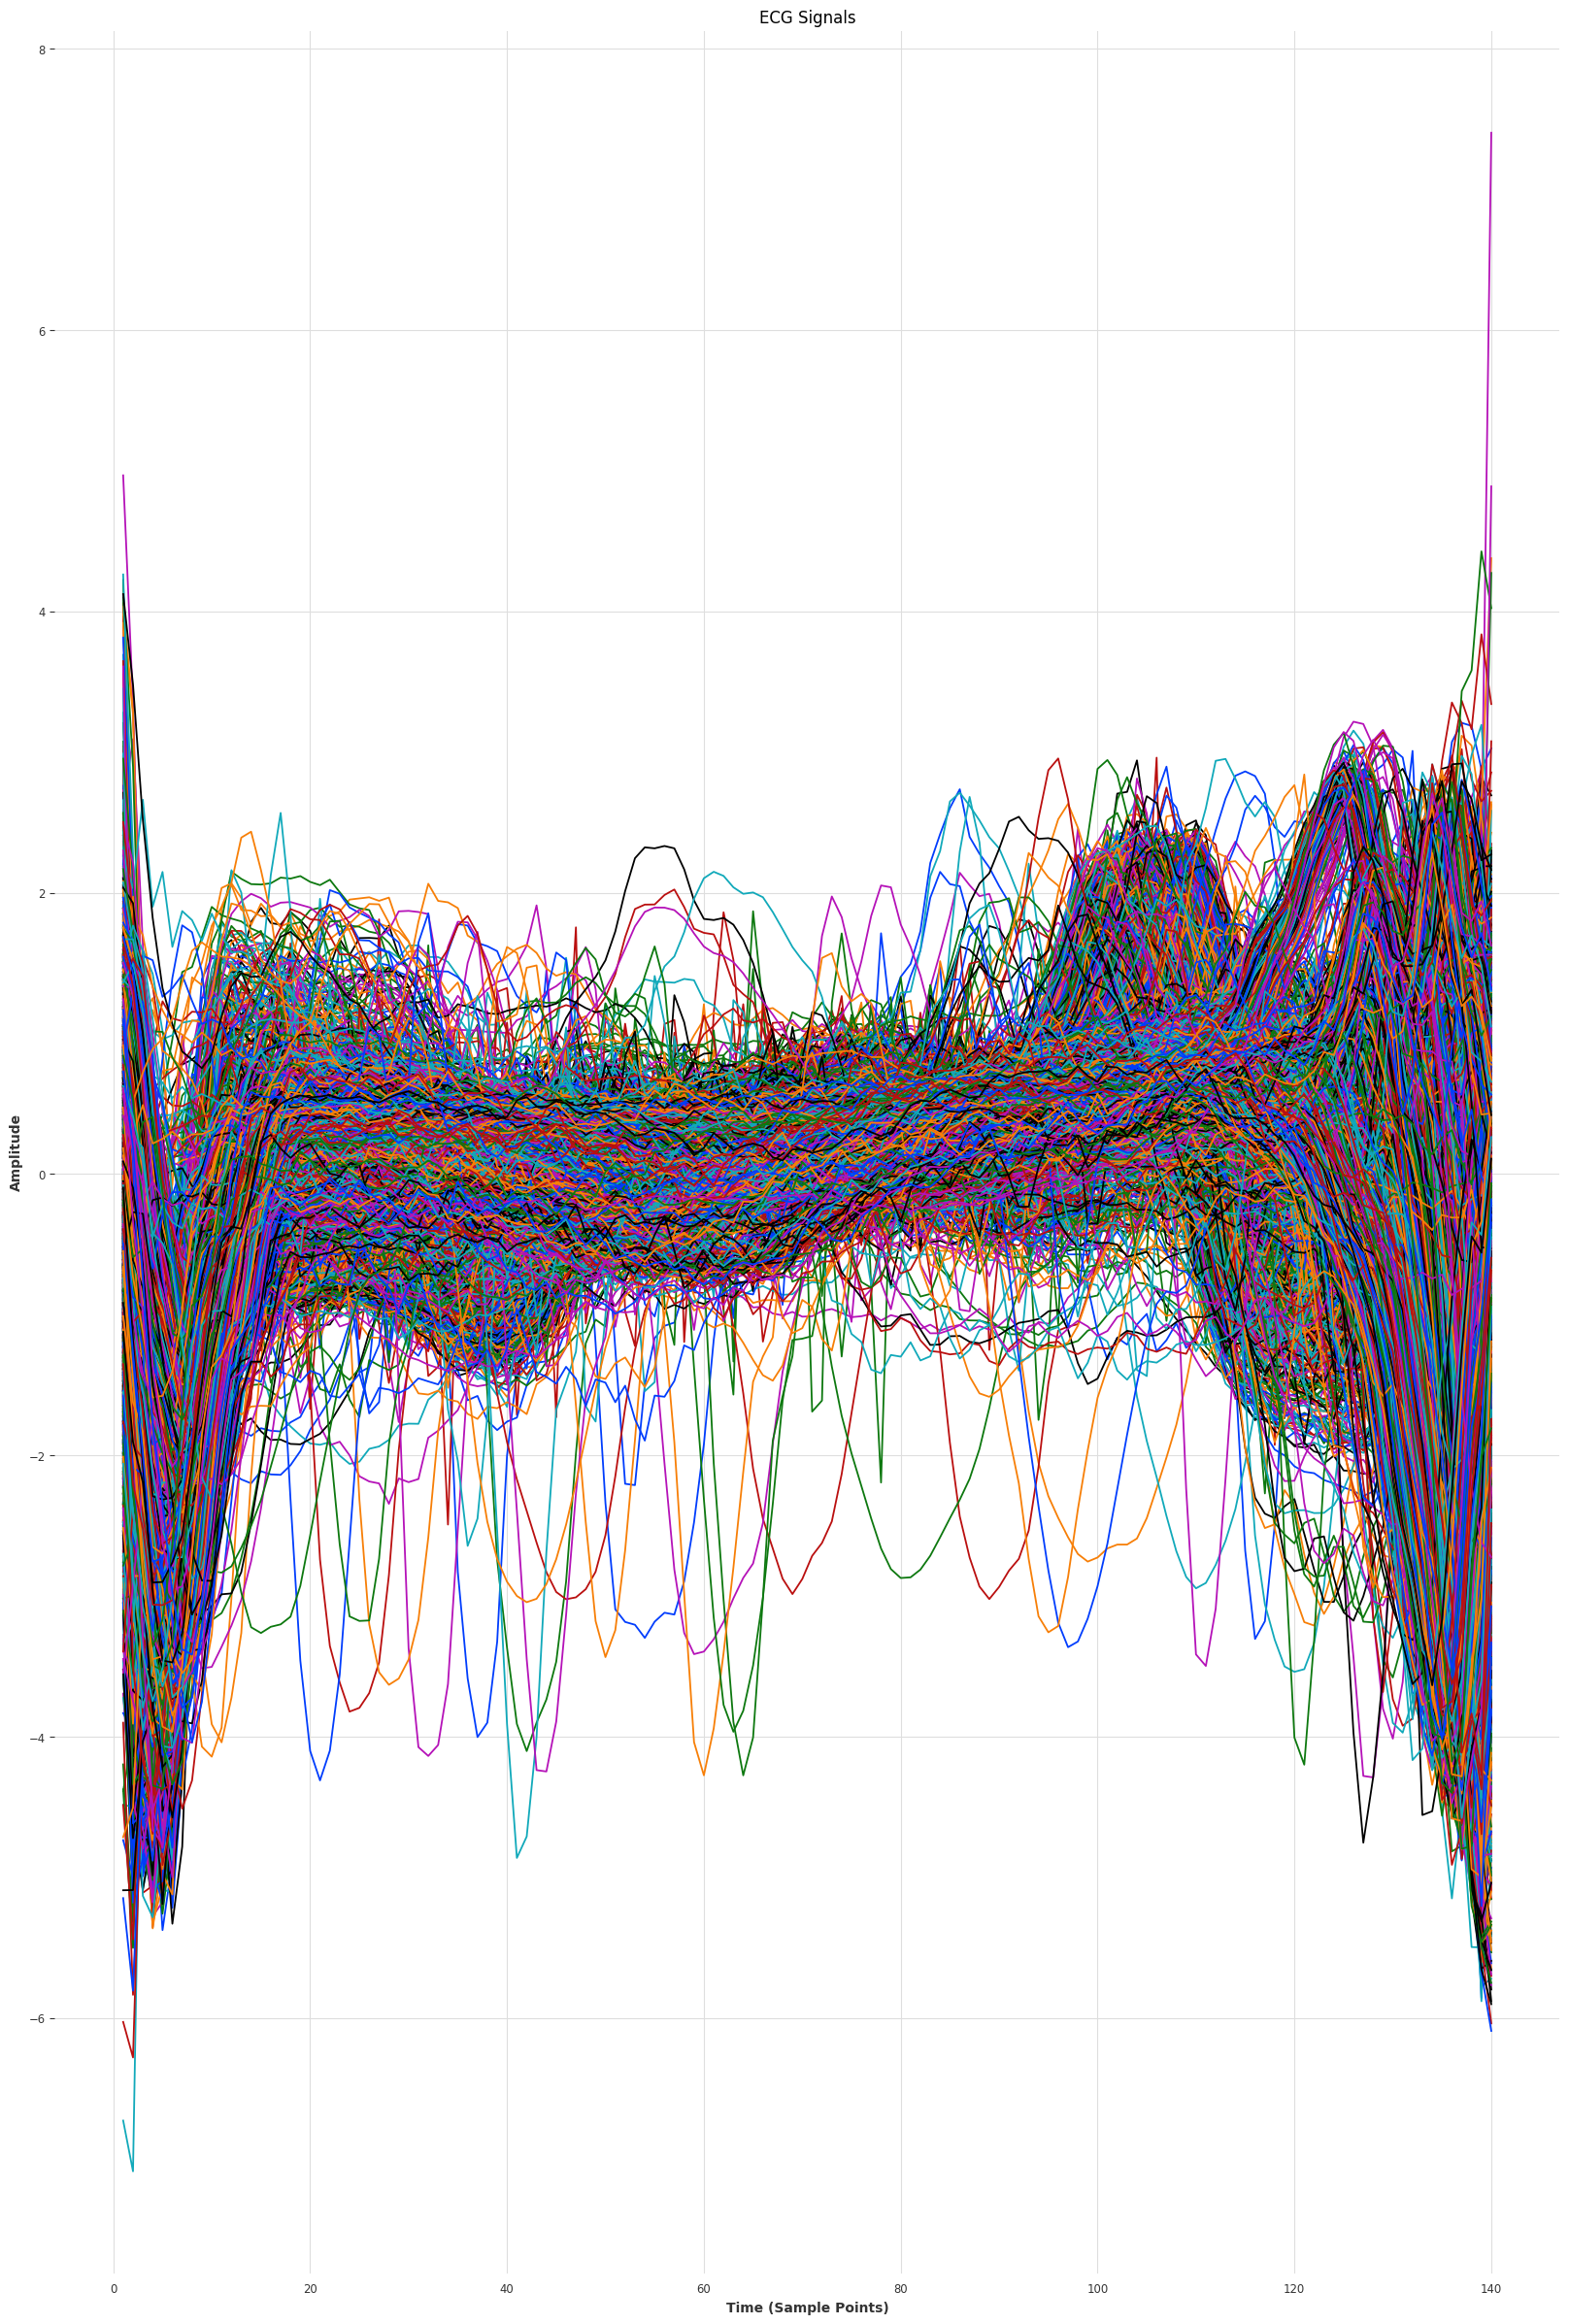

In [9]:
ecg_signals = df.iloc[:, 1:]

plt.figure(figsize=(20, 30))
for index, row in ecg_signals.iterrows():
    plt.plot(row, label=f'Signal {index + 1}')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('ECG Signals')
plt.show()

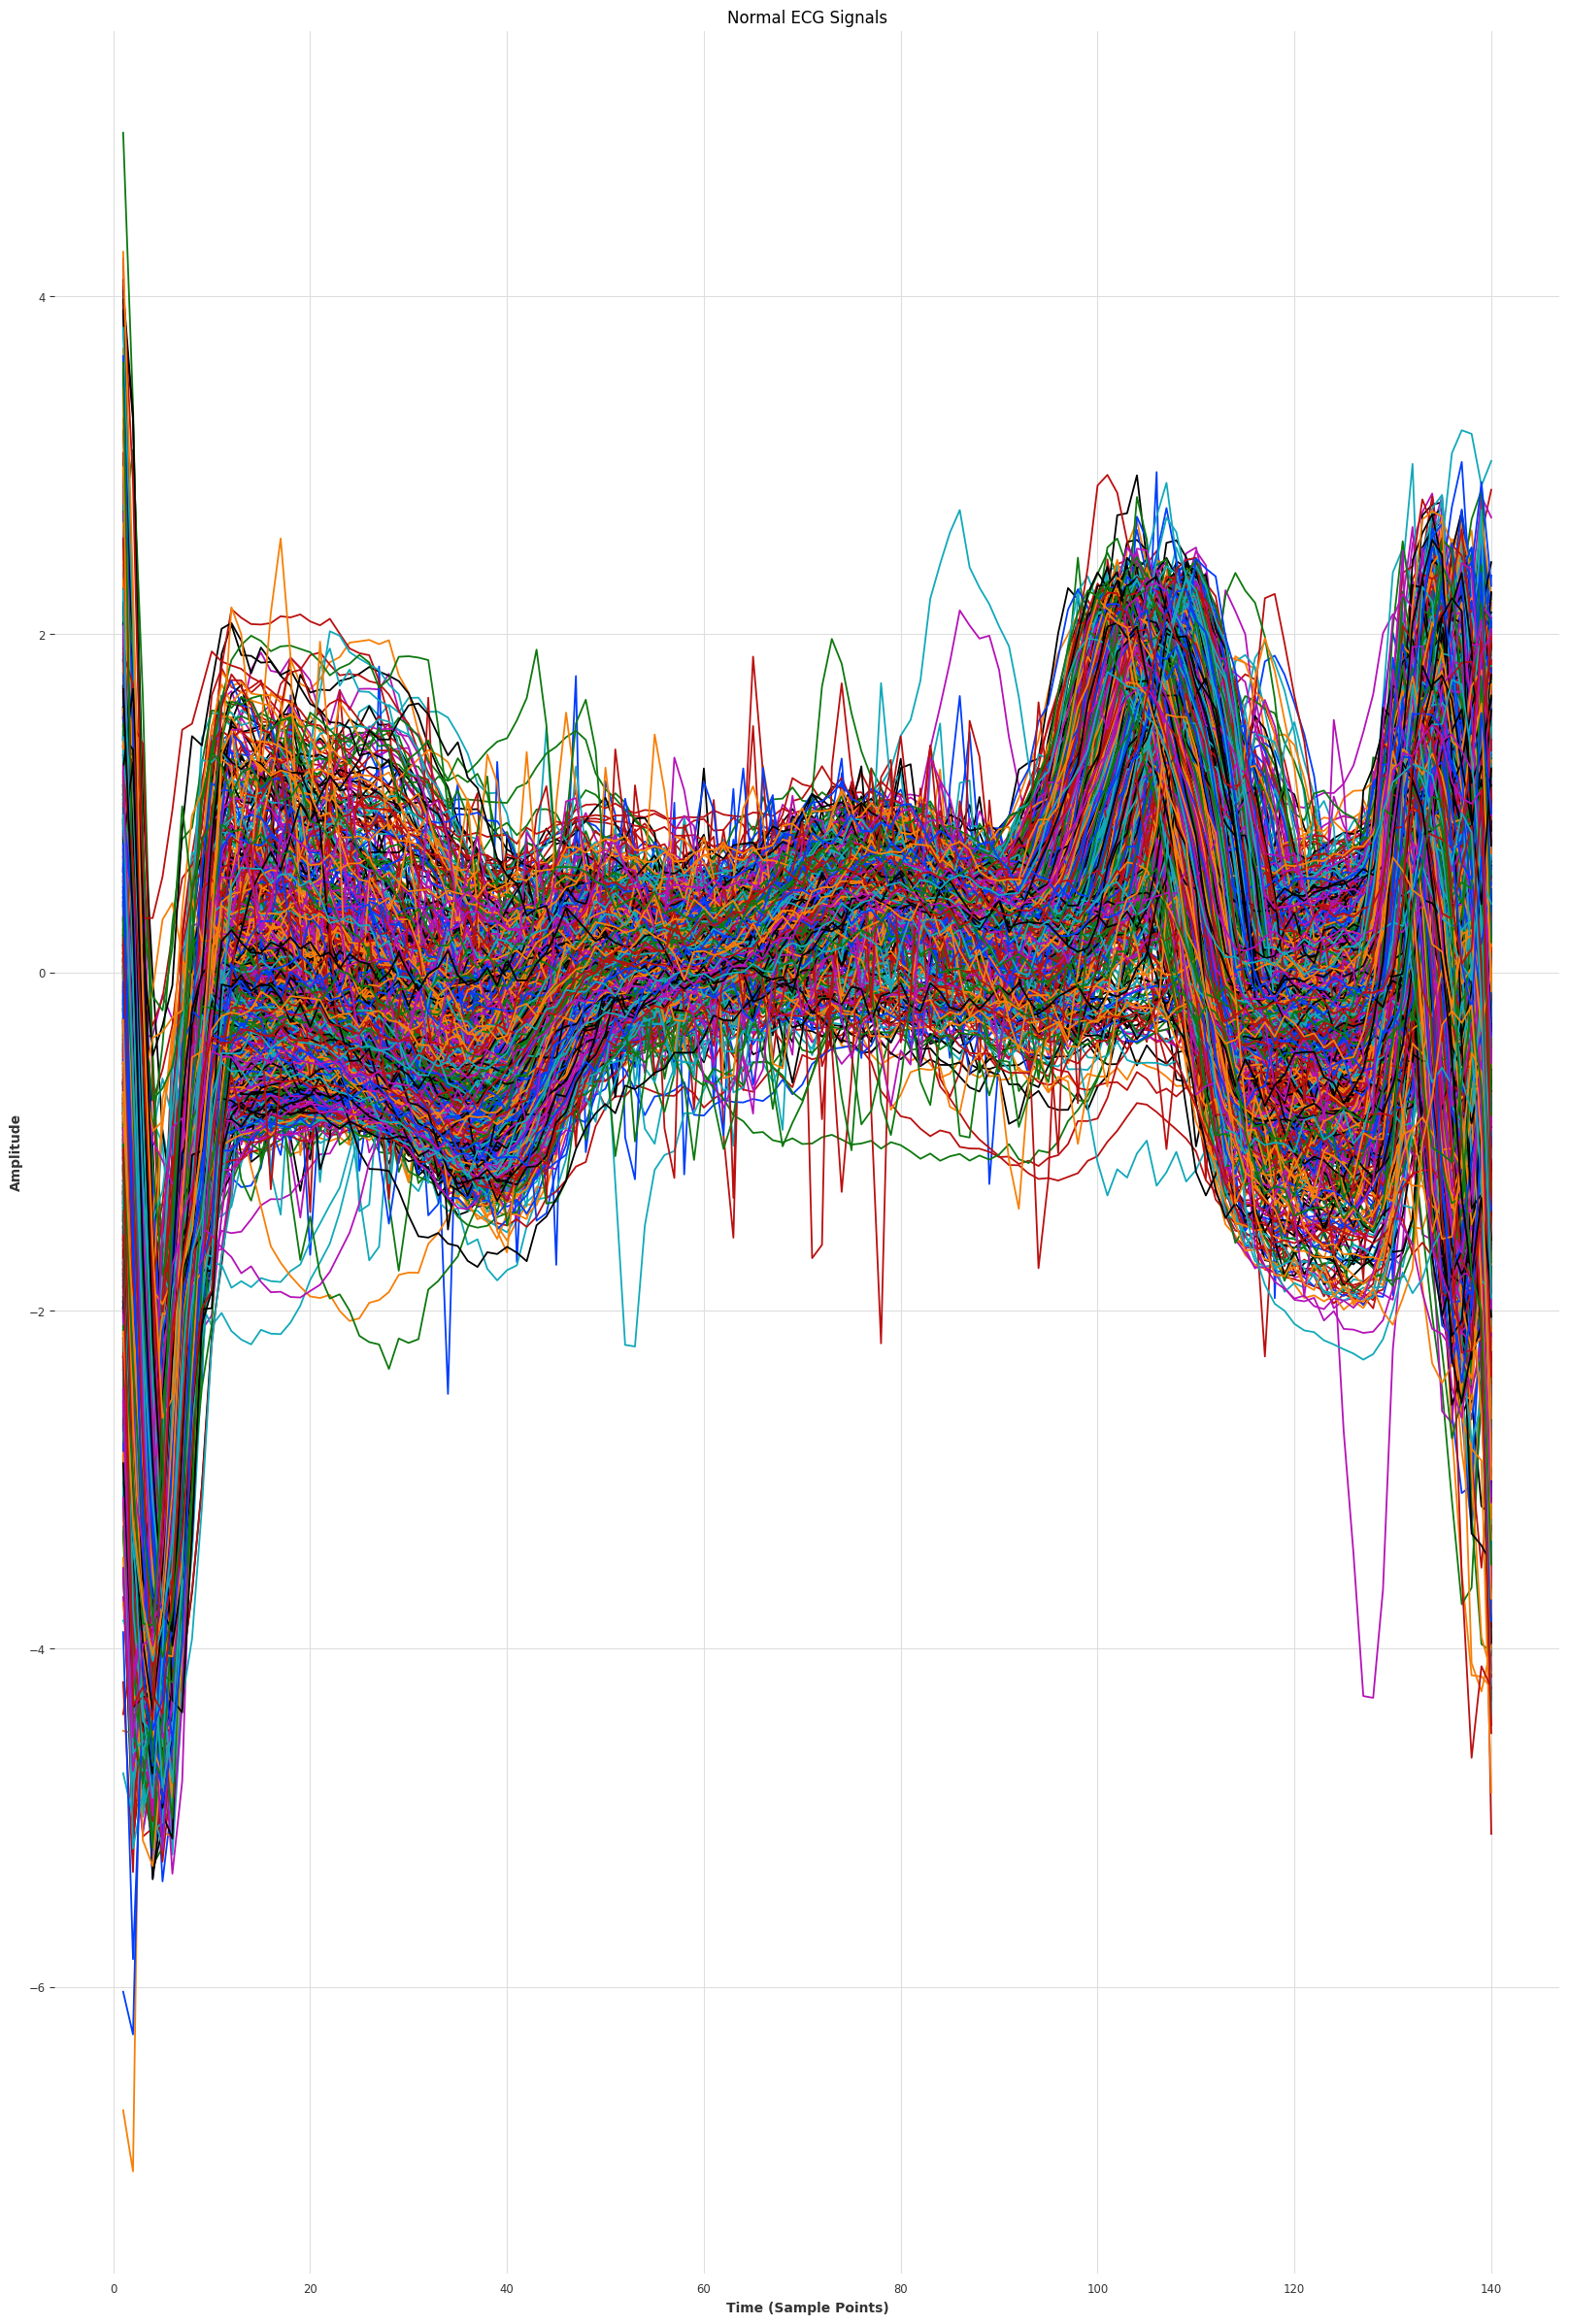

In [10]:
ecg_signals = normal_data.iloc[:, 1:]

plt.figure(figsize=(20, 30))
for index, row in ecg_signals.iterrows():
    plt.plot(row, label=f'Signal {index + 1}')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('Normal ECG Signals')
plt.show()

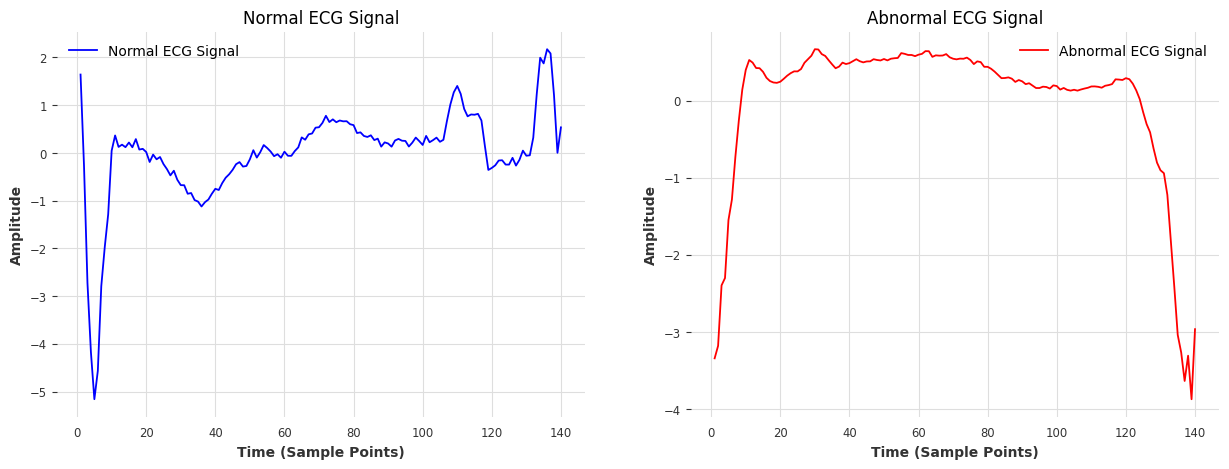

In [11]:
# Assuming normal_data contains the normal ECG signals
normal_signals = normal_data.iloc[:, 1:]  # Adjust the slicing as per your data structure
selected_normal_signal = normal_signals.iloc[random.randint(0, len(normal_signals) - 1)]

# Assuming abnormal_data contains the abnormal ECG signals
abnormal_signals = abnormal_data.iloc[:, 1:]  # Adjust the slicing as per your data structure
selected_abnormal_signal = abnormal_signals.iloc[random.randint(0, len(abnormal_signals) - 1)]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the normal ECG signal
axs[0].plot(selected_normal_signal, label='Normal ECG Signal', color='blue')
axs[0].set_xlabel('Time (Sample Points)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Normal ECG Signal')
axs[0].legend()

# Plot the abnormal ECG signal
axs[1].plot(selected_abnormal_signal, label='Abnormal ECG Signal', color='red')
axs[1].set_xlabel('Time (Sample Points)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Abnormal ECG Signal')
axs[1].legend()

# Display the plot
plt.show()


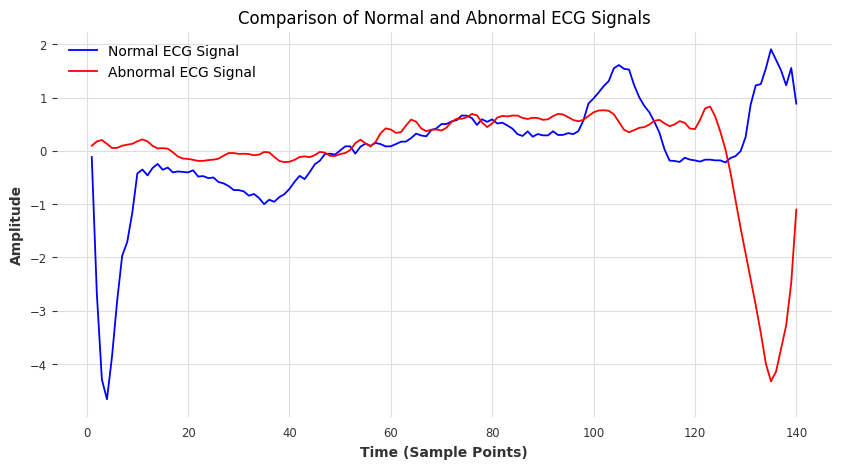

In [12]:
# Assuming ecg_signals contains the normal data
normal_signals = normal_data.iloc[:, 1:]  # Adjust the slicing as per your data structure
selected_normal_signal = normal_signals.iloc[random.randint(0, len(normal_signals) - 1)]

# Assuming ecg_signals contains the abnormal data
abnormal_signals = abnormal_data.iloc[:, 1:]  # Adjust the slicing as per your data structure
selected_abnormal_signal = abnormal_signals.iloc[random.randint(0, len(abnormal_signals) - 1)]

# Plotting both normal and abnormal signals on the same plot
plt.figure(figsize=(10, 5))
plt.plot(selected_normal_signal, label='Normal ECG Signal', color='blue')
plt.plot(selected_abnormal_signal, label='Abnormal ECG Signal', color='red')
plt.xlabel('Time (Sample Points)')
plt.ylabel('Amplitude')
plt.title('Comparison of Normal and Abnormal ECG Signals')
plt.legend()
plt.show()

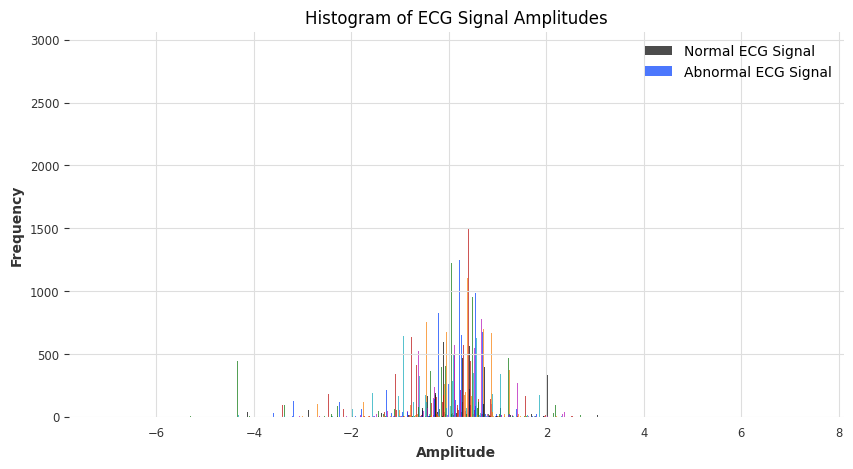

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(normal_data, bins=75, alpha=0.7, label='Normal ECG Signal')
plt.hist(abnormal_data, bins=75, alpha=0.7, label='Abnormal ECG Signal')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Histogram of ECG Signal Amplitudes')
plt.legend()
plt.show()

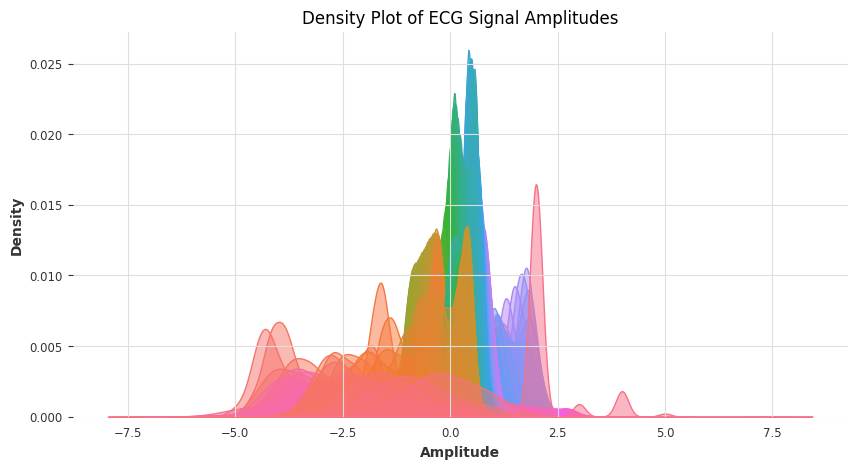

In [14]:
plt.figure(figsize=(10, 5))

# Plot density for normal ECG signals without labels in the legend
sns.kdeplot(normal_data, fill=True, alpha=0.5, color='blue', legend=False)

# Plot density for abnormal ECG signals without labels in the legend
sns.kdeplot(abnormal_data, fill=True, alpha=0.5, color='red', legend=False)

plt.xlabel('Amplitude')
plt.ylabel('Density')
plt.title('Density Plot of ECG Signal Amplitudes')
plt.show()

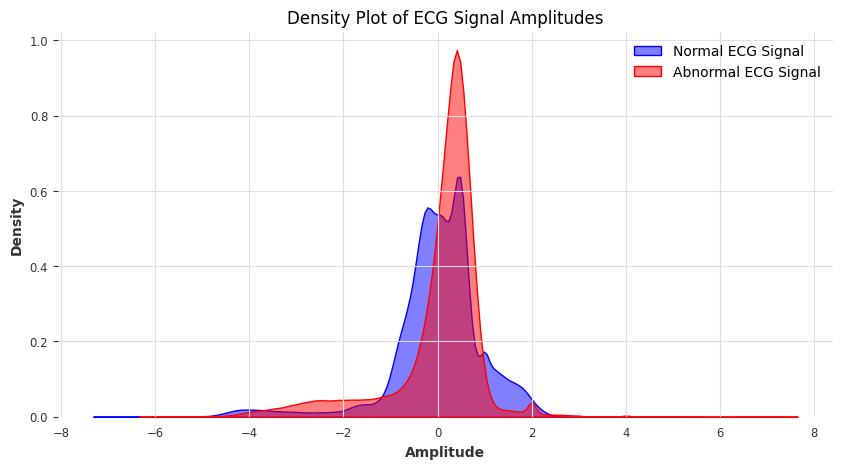

In [15]:
# Combine all columns of normal and abnormal data into single series
normal_combined = normal_data.values.flatten()
abnormal_combined = abnormal_data.values.flatten()

# Plotting the density plots
plt.figure(figsize=(10, 5))
sns.kdeplot(normal_combined, label='Normal ECG Signal', fill=True, alpha=0.5, color='blue')
sns.kdeplot(abnormal_combined, label='Abnormal ECG Signal', fill=True, alpha=0.5, color='red')
plt.xlabel('Amplitude')
plt.ylabel('Density')
plt.title('Density Plot of ECG Signal Amplitudes')
plt.legend()
plt.show()


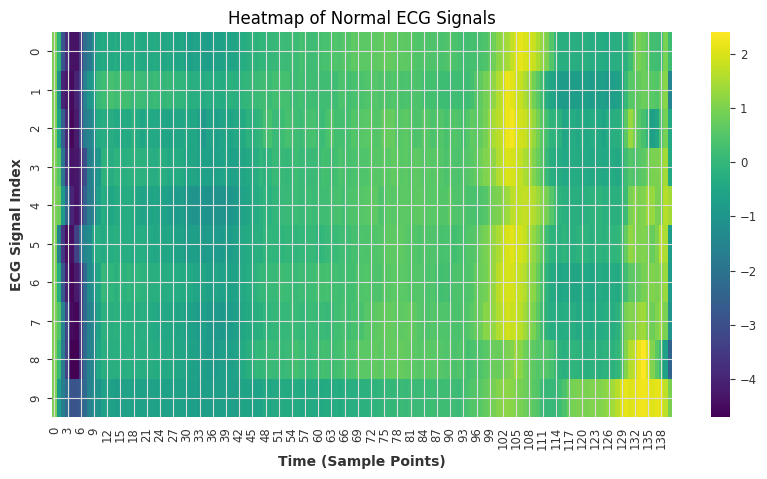

In [16]:
plt.figure(figsize=(10, 5))
sns.heatmap(normal_data.iloc[:10, :], cmap='viridis')
plt.xlabel('Time (Sample Points)')
plt.ylabel('ECG Signal Index')
plt.title('Heatmap of Normal ECG Signals')
plt.show()

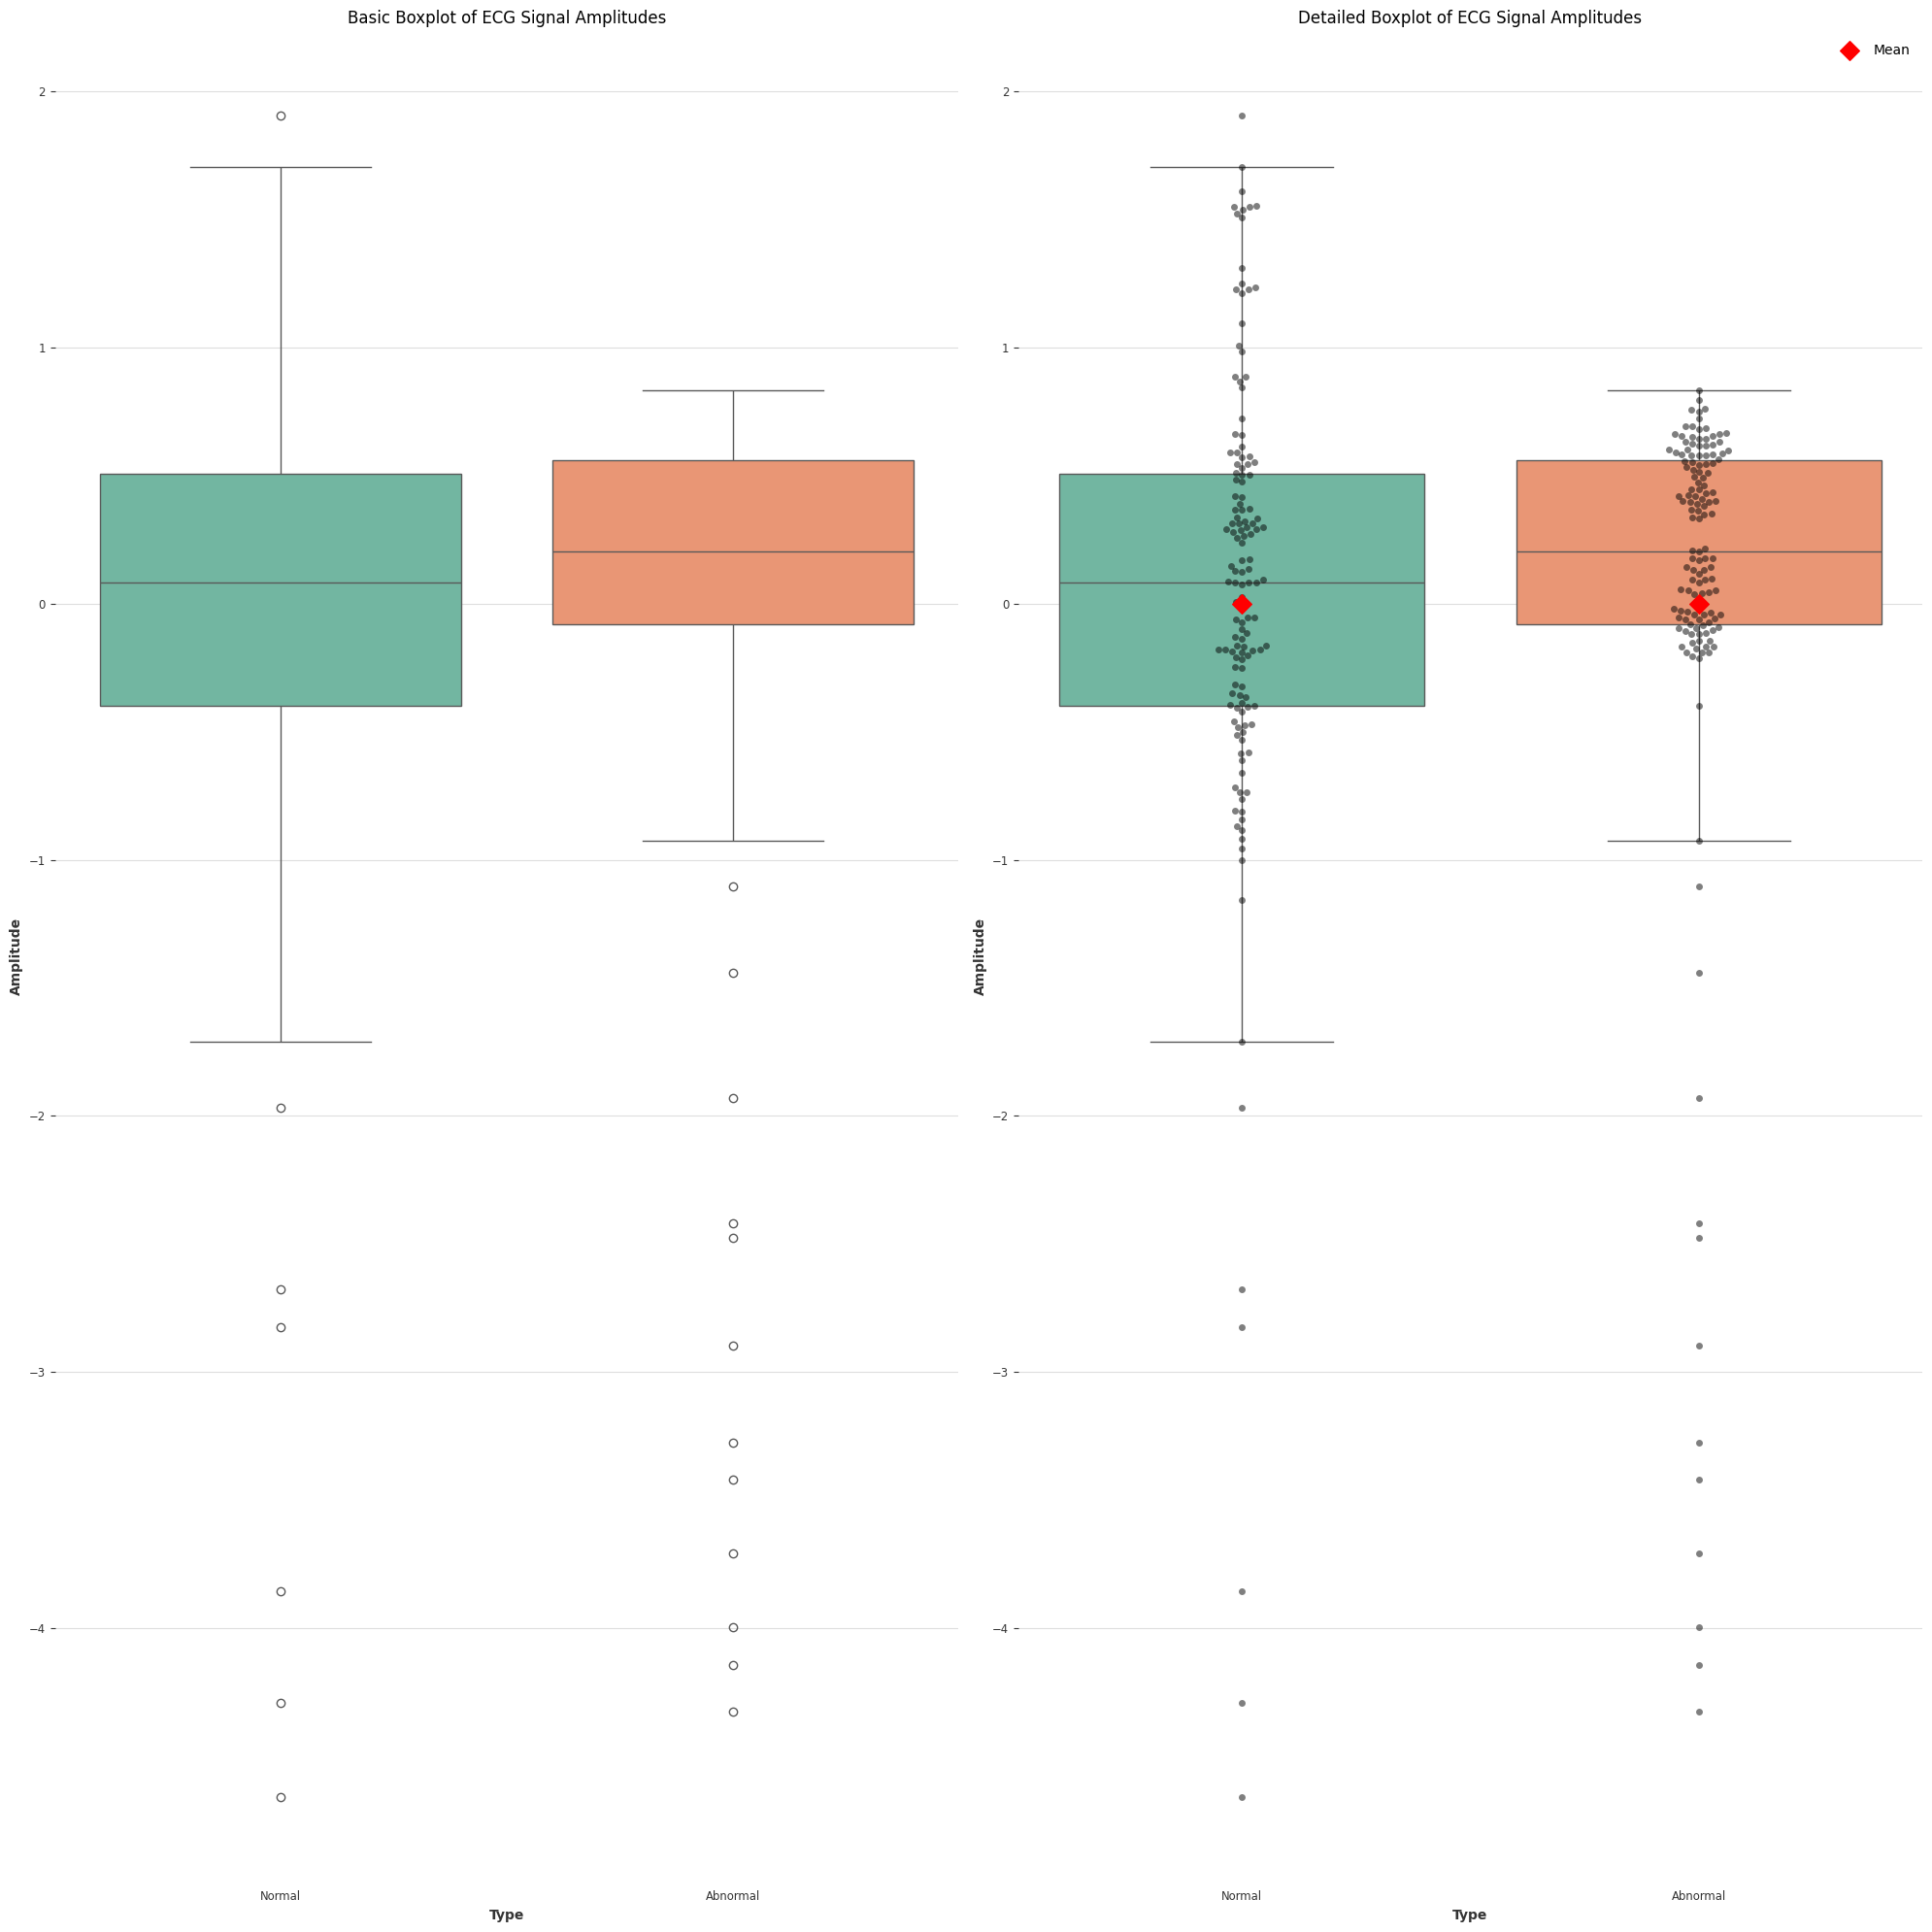

In [17]:
# Create a DataFrame for plotting
boxplot_data = pd.DataFrame({
    'Amplitude': pd.concat([selected_normal_signal, selected_abnormal_signal]),
    'Type': ['Normal'] * len(selected_normal_signal) + ['Abnormal'] * len(selected_abnormal_signal)
})

plt.figure(figsize=(20, 20))

# Basic Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='Type', y='Amplitude', data=boxplot_data, palette='Set2')
plt.title('Basic Boxplot of ECG Signal Amplitudes')

# Detailed Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='Type', y='Amplitude', data=boxplot_data, palette='Set2', showfliers=False)
sns.swarmplot(x='Type', y='Amplitude', data=boxplot_data, color='k', alpha=0.5, dodge=True)

# Add mean markers
mean_values = boxplot_data.groupby('Type')['Amplitude'].mean()
for i, mean in enumerate(mean_values):
    plt.scatter(x=i, y=mean, color='red', marker='D', s=100, label='Mean' if i == 0 else "", zorder=10)

plt.title('Detailed Boxplot of ECG Signal Amplitudes')
plt.legend()

plt.tight_layout()
plt.show()

# Remove Label column

In [18]:
normal_data.drop(normal_data.columns[0], axis=1, inplace=True)
abnormal_data.drop(abnormal_data.columns[0], axis=1, inplace=True)

In [19]:
normal_data.head()

1         2         3         4         5         6         7    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        8         9         10   ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.160348  0.792168  0.933541  0.796958   
1 -0.992258 -0.754680  0.042321  ...  0.560327  0.538356  0.656881  0.787490   
2 -1.490659 -1.183580 -0.394229  ...  1.284825  0.886073  0.531452  0.311377   
3 -1.671131 -1.333884 -0.965629  ...  0.491173  0.350816  0.499111  0.600345   
4 -1.783423 -1.594450 -0.753199  ...  0.966606  1.148884  0.958434  1.059025   

        135       136       137       138       139       140  
0  0.578621  0.257740  0.228077  0.123431  0.925286  0.193137  
1  0.724046  0.555784  0.476333  0.773820  1.119621 -1.436250  
2 -0.021919 -0.713683 -0.532197  0.321097  0.904227 -0.421797  
3  0.842069  0.952074  0.990133  1.086798  1.403011 -0.383564  
4  1.371682  1.277392  0.960304  0.971020  1.614392  1.421456  

[5 rows x 140 columns]

In [20]:
abnormal_data.head()

1         2         3         4         5         6         7    \
292 -0.032245 -0.545050 -0.822340 -1.605085 -1.805775 -2.008067 -2.233975   
293 -0.003377 -0.279265 -0.230519 -0.635978 -0.894795 -1.023105 -1.243738   
294  0.195989 -0.222258 -0.754773 -1.415614 -1.775851 -2.162326 -2.467492   
295  0.894867 -0.003822 -0.751052 -1.396543 -1.737838 -2.113020 -2.213210   
296  1.250060  0.760800  0.042925 -0.627974 -0.963454 -1.261335 -1.652440   

          8         9         10   ...       131       132       133  \
292 -2.191458 -2.058071 -1.880849  ... -0.906425 -1.621376 -2.329090   
293 -1.458372 -1.677896 -1.784530  ... -2.155969 -2.640508 -3.218384   
294 -2.331384 -1.993476 -1.611709  ... -0.162438 -0.935030 -1.654340   
295 -2.203347 -2.024191 -1.591458  ... -0.899746 -1.441516 -1.861612   
296 -1.888433 -1.935217 -1.808429  ... -0.695282 -0.979223 -1.353969   

          134       135       136       137       138       139       140  
292 -3.049894 -3.620413 -4.210482 -4.043785 -3.051813 -2.806866 -0.879666  
293 -3.651630 -3.881198 -3.924672 -3.164390 -2.228373 -1.837544 -0.378489  
294 -2.434240 -3.472170 -4.280780 -4.629438 -3.794192 -2.851468 -1.743521  
295 -2.321381 -2.884877 -3.530246 -4.412515 -3.903331 -3.567106 -1.536338  
296 -1.952051 -2.640386 -3.000281 -3.812490 -3.973360 -5.221946 -3.661793  

[5 rows x 140 columns]

# Train, Validation and Test Split

In [21]:
# Split into training and remaining (test + validation)
train_data, temp_data = train_test_split(normal_data, test_size=0.3, random_state=42)

# Split the remaining data into test and validation
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the shapes of the datasets
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (2043, 140)
Validation Data Shape: (438, 140)
Test Data Shape: (438, 140)


# Scaling

In [22]:
# Initialize RobustScaler
scaler = RobustScaler()

# Fit on training data and transform train, validation, and test sets
train_features_scaled = scaler.fit_transform(train_data)
val_features_scaled = scaler.transform(val_data)
test_features_scaled = scaler.transform(test_data)

# Convert scaled features back to DataFrames if needed
train_data_scaled = pd.DataFrame(train_features_scaled, columns=train_data.columns)
val_data_scaled = pd.DataFrame(val_features_scaled, columns=val_data.columns)
test_data_scaled = pd.DataFrame(test_features_scaled, columns=test_data.columns)

# Remove Index

In [23]:
# Remove index

train_data_scaled.reset_index(drop=True, inplace=True)
val_data_scaled.reset_index(drop=True, inplace=True)
test_data_scaled.reset_index(drop=True, inplace=True)

In [24]:
train_data_scaled.head()

1         2         3         4         5         6         7    \
0  0.839248  1.292283  0.987485  0.058345 -0.582377 -0.373762 -0.449916   
1 -0.275807 -0.535190 -0.549554 -0.174845  0.699793  0.944599  0.479219   
2  2.236716  2.393658  2.049168  2.304653  0.539377 -0.421353 -0.344713   
3  1.476550  1.260409  0.854183  0.796802 -1.817792 -1.646699 -1.127945   
4  1.277607  1.551714  2.403606  4.610046  5.983843  3.247492  2.489437   

        8         9         10   ...       131       132       133       134  \
0 -0.664856 -0.589748 -0.197084  ... -0.265375 -0.391869  0.341800  0.030879   
1  0.247840  1.102784  0.345155  ... -0.242300  0.568572  0.447589  0.200100   
2  1.040576 -0.010265  0.077206  ... -3.617046 -4.518786 -3.326732 -2.212527   
3 -0.656004 -0.450035  0.202898  ... -1.802146 -1.332376  0.113713 -0.013878   
4  5.856462  3.375615  2.787641  ... -2.107139 -2.921694 -2.676259 -2.022617   

        135       136       137       138       139       140  
0 -0.143932 -0.335826 -0.122299  0.254380  0.024934 -0.256850  
1  0.281066  0.235796  0.120509 -0.021199  0.342718  0.782722  
2 -1.306004 -0.521562 -0.267923 -0.314913 -0.710822  0.346269  
3  0.549608  0.718334  0.726344  0.189126 -0.472769  0.592118  
4 -1.537035 -1.412944 -1.248509 -1.059544 -0.997188 -0.777456  

[5 rows x 140 columns]

In [25]:
val_data_scaled.head()

1         2         3         4         5         6         7    \
0  0.750357  0.852963  0.965864  0.579018 -0.926328 -0.429219 -0.244146   
1 -0.232572 -0.484082 -0.975487 -1.083936  0.347355  0.930090  0.456502   
2 -1.339746 -0.801949  0.085771  1.537477  3.064569  1.788985  1.001394   
3 -0.110850  0.100078  0.209918  0.430417 -0.349739 -0.709733 -1.014447   
4  0.769570  1.241408  1.233795  1.644781  0.524437 -0.511335 -0.962382   

        8         9         10   ...       131       132       133       134  \
0  0.134767 -0.158884 -0.471762  ... -1.321766  0.246949  0.552940  0.391209   
1  0.376071  1.292512  0.654961  ...  0.203307  1.062086  1.302732  1.830119   
2  2.020424  1.183799 -0.007059  ...  0.494266  0.536919  0.814092  0.698090   
3 -1.103302 -0.274366 -0.880011  ...  0.646830 -0.017139 -0.771633 -1.684558   
4 -1.097533 -0.599829 -0.797315  ... -1.263062 -0.974661  0.590282  0.441693   

        135       136       137       138       139       140  
0  0.221683 -0.181374 -0.697761 -1.177477 -0.638017  0.119817  
1  1.638289  0.812214 -0.121036 -0.477357 -0.543493 -0.681321  
2  0.744623  0.764270  0.655669  0.536940  0.565367  0.602061  
3 -1.889304 -1.673978 -1.516479 -1.121566 -0.869257 -0.726706  
4  0.341100  0.596821  0.090161 -0.555547 -1.052988  0.183906  

[5 rows x 140 columns]

In [26]:
test_data_scaled.head()

1         2         3         4         5         6         7    \
0 -0.132394 -0.641296 -0.426380 -0.377511 -0.162521  0.780756  0.481302   
1  0.658419  1.343169  1.101458  1.522987 -0.091359 -0.666563 -0.691936   
2 -0.178278 -0.033876  0.243537 -0.090738 -0.510682 -0.155648  0.033961   
3  0.602227  1.465693  1.771358  2.115425  1.200210 -0.910575 -1.898675   
4  0.420857  0.352492  0.198599 -0.277100 -0.774639 -0.224593 -0.147538   

        8         9         10   ...       131       132       133       134  \
0  0.064879  0.935561  0.897901  ... -0.042536  0.537542  0.401006  0.234686   
1 -1.256640 -0.722822 -0.505430  ... -1.159002 -1.512846 -0.839990  0.172942   
2  0.695595 -0.033554 -0.123223  ... -0.333087  1.442914  1.794423  0.885432   
3 -3.691682 -0.880959 -1.424594  ... -0.621712  0.188786 -0.166474  0.106073   
4 -0.111258 -0.323437 -0.264717  ...  0.353095  0.010004  0.154042  0.156500   

        135       136       137       138       139       140  
0 -0.362604 -0.592130 -0.584513 -0.252685  0.100435 -0.922608  
1  0.137219  0.689427  0.593272  0.444617 -0.119738  0.785213  
2  0.269237 -0.426821 -1.288132 -1.834308 -1.485398 -0.196290  
3  0.011692 -0.204001 -0.687580 -1.372603 -0.972027 -0.147814  
4  0.197993  0.179637  0.181484  0.492402  0.604920  0.270792  

[5 rows x 140 columns]

In [27]:
#%% Printing infos
train_data_scaled.info()
val_data_scaled.info()
test_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 2.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 479.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 140 entries, 1 to 140
dtypes: float64(140)
memory usage: 479.2 KB


# Adding TimeSeries

In [28]:
train_series = TimeSeries.from_dataframe(train_data_scaled)
val_series = TimeSeries.from_dataframe(val_data_scaled)
test_series = TimeSeries.from_dataframe(test_data_scaled)
train_series = train_series.astype(np.float32)
val_series = val_series.astype(np.float32)
test_series = test_series.astype(np.float32)

In [29]:
train_series.head(5)

<TimeSeries (DataArray) (time: 5, component: 140, sample: 1)> Size: 3kB
array([[[ 8.39247704e-01],
        [ 1.29228318e+00],
        [ 9.87485409e-01],
        [ 5.83454520e-02],
        [-5.82376599e-01],
        [-3.73761624e-01],
        [-4.49915498e-01],
        [-6.64856434e-01],
        [-5.89747727e-01],
        [-1.97084084e-01],
        [ 6.87198997e-01],
        [ 5.96488953e-01],
        [ 7.47947544e-02],
        [ 1.91107899e-01],
        [-1.48426056e-01],
        [-2.02052802e-01],
        [-1.39414519e-01],
        [ 8.78619105e-02],
        [ 1.99894458e-01],
        [ 2.66805738e-01],
...
        [-4.28017378e+00],
        [-4.03510714e+00],
        [-4.18219042e+00],
        [-3.99335623e+00],
        [-4.05390215e+00],
        [-4.05564976e+00],
        [-4.16602802e+00],
        [-3.72976947e+00],
        [-2.62017918e+00],
        [-1.61012936e+00],
        [-2.10713840e+00],
        [-2.92169356e+00],
        [-2.67625952e+00],
        [-2.02261662e+00],
        [-1.53703499e+00],
        [-1.41294348e+00],
        [-1.24850881e+00],
        [-1.05954397e+00],
        [-9.97188151e-01],
        [-7.77455807e-01]]], dtype=float32)
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) <U3 2kB '1' '2' '3' '4' ... '137' '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [30]:
val_series.head(5)

<TimeSeries (DataArray) (time: 5, component: 140, sample: 1)> Size: 3kB
array([[[ 7.50357151e-01],
        [ 8.52963269e-01],
        [ 9.65864122e-01],
        [ 5.79018235e-01],
        [-9.26327705e-01],
        [-4.29219246e-01],
        [-2.44146332e-01],
        [ 1.34766966e-01],
        [-1.58884436e-01],
        [-4.71761793e-01],
        [ 1.48806358e-02],
        [ 1.56604871e-01],
        [ 3.25903356e-01],
        [-3.36248018e-02],
        [ 3.00818048e-02],
        [ 5.20868860e-02],
        [ 1.98511362e-01],
        [ 2.64527380e-01],
        [ 1.06026515e-01],
        [ 4.81281519e-01],
...
        [ 7.01315403e-02],
        [-5.72296418e-02],
        [ 1.48328856e-01],
        [ 2.03496814e-01],
        [-6.56103855e-03],
        [-2.00159084e-02],
        [-1.48976922e-01],
        [-3.89114290e-01],
        [-5.93819499e-01],
        [-8.14140618e-01],
        [-1.26306200e+00],
        [-9.74660575e-01],
        [ 5.90282321e-01],
        [ 4.41692859e-01],
        [ 3.41100216e-01],
        [ 5.96821189e-01],
        [ 9.01606679e-02],
        [-5.55546701e-01],
        [-1.05298793e+00],
        [ 1.83906168e-01]]], dtype=float32)
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) <U3 2kB '1' '2' '3' '4' ... '137' '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [31]:
test_series.head(5)

<TimeSeries (DataArray) (time: 5, component: 140, sample: 1)> Size: 3kB
array([[[-1.32393837e-01],
        [-6.41295791e-01],
        [-4.26379889e-01],
        [-3.77510995e-01],
        [-1.62520975e-01],
        [ 7.80756176e-01],
        [ 4.81302053e-01],
        [ 6.48785233e-02],
        [ 9.35561359e-01],
        [ 8.97900760e-01],
        [ 6.48413479e-01],
        [ 4.37062055e-01],
        [ 4.98988122e-01],
        [ 4.21544790e-01],
        [ 6.36175573e-01],
        [ 7.15150714e-01],
        [ 5.25784612e-01],
        [ 1.82345390e-01],
        [ 7.53757581e-02],
        [ 4.92000096e-02],
...
        [ 1.83541745e-01],
        [-4.54273932e-02],
        [ 2.91098237e-01],
        [ 2.26096272e-01],
        [ 1.85477689e-01],
        [ 2.89207757e-01],
        [ 2.22837493e-01],
        [ 1.94250301e-01],
        [ 3.10655236e-01],
        [ 4.53027159e-01],
        [ 3.53094995e-01],
        [ 1.00044012e-02],
        [ 1.54041767e-01],
        [ 1.56499520e-01],
        [ 1.97992906e-01],
        [ 1.79637328e-01],
        [ 1.81483626e-01],
        [ 4.92401630e-01],
        [ 6.04920030e-01],
        [ 2.70791829e-01]]], dtype=float32)
Coordinates:
  * time       (time) int64 40B 0 1 2 3 4
  * component  (component) <U3 2kB '1' '2' '3' '4' ... '137' '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# Model Architecture

In [32]:
class LossLoggingCallback(Callback):
    def __init__(self):
        self.metrics = {"epochs": [], "train_loss": [], "val_loss": []}
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss", None)
        if train_loss is not None:
            train_loss = train_loss.item()
            self.train_losses.append(train_loss)
            print(f"Train epoch end: recorded train loss {train_loss}")

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss", None)
        print("Validation Epoch End Callback Triggered")  # Debugging Line
        if val_loss is not None:
            val_loss = val_loss.item()
            self.val_losses.append(val_loss)
            print(f"Validation epoch end: recorded validation loss {val_loss}")

            # Append new metrics
            epoch = trainer.current_epoch
            self.metrics["epochs"].append(epoch)
            self.metrics["train_loss"].append(self.train_losses[-1] if self.train_losses else None)
            self.metrics["val_loss"].append(val_loss)


# Define the TCN model
ecg_model = TCNModel(
    input_chunk_length=50,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=32,
    num_layers=3,
    dropout=0.2,
    optimizer_cls=Adam,
    optimizer_kwargs={"lr": 0.001},
    random_state=42
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=10,          # Number of epochs to wait for improvement
    mode="max"           # Mode should be 'min' for loss metrics
)

# Create the loss logging callback instance
loss_callback = LossLoggingCallback()

# Initialize the trainer with callbacks
trainer = Trainer(
    callbacks=[early_stopping_callback, loss_callback],
    max_epochs=100,
    logger=True,
    enable_progress_bar=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [33]:
ecg_model.fit(train_series, val_series=val_series, trainer=trainer)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 48.6 K | train
-------------------------------------------------------------
48.6 K    Trainable params
0         Non-trainable params
48.6 K    Total params
0.194     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s]Validation Epoch End Callback Triggered
Validation epoch end: recorded validation loss 1.0113868713378906
Epoch 0: 100%|██████████| 62/62 [00:06<00:00, 10.21it/s, v_num=27, train_loss=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 23.05it/s]Validation Epoch End Callback Triggered
Validation epoch end: recorded validation loss 1.0361645221710205

Epoch 1: 100%|██████████| 62/62 [00:06<00:00,  9.40it/s, v_num=27, train_loss=0.884, val_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 17.37it/s]Validation Epoch End Callback Triggered
Validation epoch end: recorded validation loss 1.0399836301803589

Epoch 2: 100%|██████████| 62/62 [00:09<00:00,  6.33it/s, v_num=27, train_loss=0.769, val_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████

TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=32, num_layers=3, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=50, output_chunk_length=30, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001}, random_state=42)

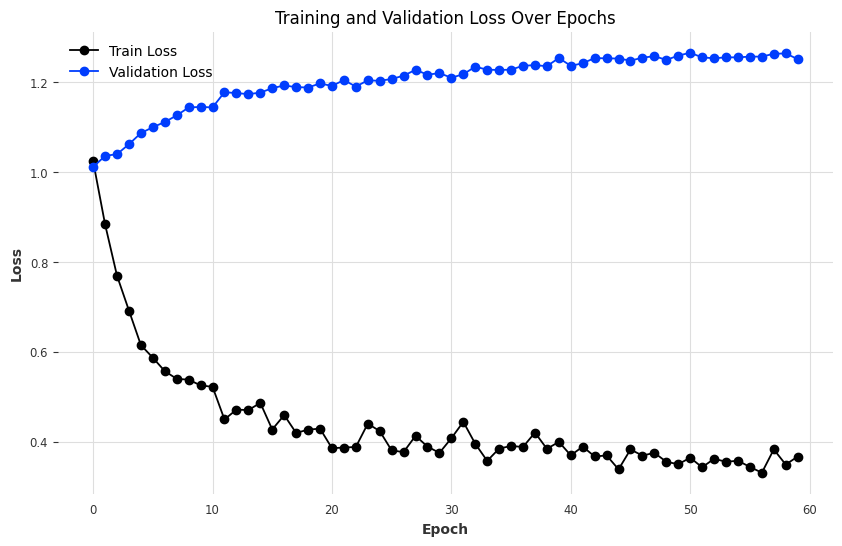

In [34]:
# Make sure to have matching lengths for epochs, train_losses, and val_losses
epochs = range(len(loss_callback.train_losses))

# Ensure that the lengths match
num_train_epochs = len(loss_callback.train_losses)
num_val_epochs = len(loss_callback.val_losses)

# Adjust val_losses if it has more entries than train_losses
if num_val_epochs > num_train_epochs:
    loss_callback.val_losses = loss_callback.val_losses[:num_train_epochs]

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_callback.train_losses, label='Train Loss', marker='o')
plt.plot(epochs, loss_callback.val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Forecasting Anomaly Model

In [35]:
abnormal_features_scaled = scaler.transform(abnormal_data)
abnormal_data_scaled = pd.DataFrame(abnormal_features_scaled, columns=test_data.columns)

In [36]:
abnormal_series = TimeSeries.from_dataframe(abnormal_data_scaled)
abnormal_series = abnormal_series.astype(np.float32)

In [37]:
# instantiate the anomaly model with: one fitted model, and 3 scorers
anomaly_model = ForecastingAnomalyModel(
    model=ecg_model,
    scorer=[
        NormScorer(ord=1),
    ],
)

In [38]:
START = 0.1
anomaly_model.fit(train_series, start=START, allow_model_training=False, verbose=True, scorer=NormScorer)

In [39]:
train_series[:1]

<TimeSeries (DataArray) (time: 1, component: 140, sample: 1)> Size: 560B
array([[[ 0.8392477 ],
        [ 1.2922832 ],
        [ 0.9874854 ],
        [ 0.05834545],
        [-0.5823766 ],
        [-0.37376162],
        [-0.4499155 ],
        [-0.66485643],
        [-0.5897477 ],
        [-0.19708408],
        [ 0.687199  ],
        [ 0.59648895],
        [ 0.07479475],
        [ 0.1911079 ],
        [-0.14842606],
        [-0.2020528 ],
        [-0.13941452],
        [ 0.08786191],
        [ 0.19989446],
        [ 0.26680574],
...
        [-0.60443795],
        [-0.8601184 ],
        [-0.6313709 ],
        [-0.5481561 ],
        [-0.6624576 ],
        [-0.4839799 ],
        [-0.4139334 ],
        [ 0.13170826],
        [ 1.1768184 ],
        [ 0.73430806],
        [-0.26537517],
        [-0.3918687 ],
        [ 0.34180012],
        [ 0.03087907],
        [-0.14393185],
        [-0.33582565],
        [-0.12229874],
        [ 0.2543804 ],
        [ 0.02493429],
        [-0.25685048]]], dtype=float32)
Coordinates:
  * time       (time) int64 8B 0
  * component  (component) <U3 2kB '1' '2' '3' '4' ... '137' '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [40]:
test_series[:1]

<TimeSeries (DataArray) (time: 1, component: 140, sample: 1)> Size: 560B
array([[[-1.3239384e-01],
        [-6.4129579e-01],
        [-4.2637989e-01],
        [-3.7751099e-01],
        [-1.6252097e-01],
        [ 7.8075618e-01],
        [ 4.8130205e-01],
        [ 6.4878523e-02],
        [ 9.3556136e-01],
        [ 8.9790076e-01],
        [ 6.4841348e-01],
        [ 4.3706205e-01],
        [ 4.9898812e-01],
        [ 4.2154479e-01],
        [ 6.3617557e-01],
        [ 7.1515071e-01],
        [ 5.2578461e-01],
        [ 1.8234539e-01],
        [ 7.5375758e-02],
        [ 4.9200010e-02],
...
        [-1.4346039e-01],
        [-2.0699865e-01],
        [-5.2652642e-02],
        [ 2.6165882e-01],
        [-1.3228142e-01],
        [-4.3404514e-01],
        [-3.1931750e-02],
        [-1.4725572e-01],
        [-3.6549968e-01],
        [-3.4068480e-01],
        [-4.2535555e-02],
        [ 5.3754240e-01],
        [ 4.0100601e-01],
        [ 2.3468646e-01],
        [-3.6260423e-01],
        [-5.9212995e-01],
        [-5.8451307e-01],
        [-2.5268495e-01],
        [ 1.0043499e-01],
        [-9.2260832e-01]]], dtype=float32)
Coordinates:
  * time       (time) int64 8B 0
  * component  (component) <U3 2kB '1' '2' '3' '4' ... '137' '138' '139' '140'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [41]:
anomaly_scores, model_forecasting = anomaly_model.score(
    test_series, start=START, return_model_prediction=True, verbose=True
)
pred_start = model_forecasting.start_time()

`start` value `0.1` corresponding to timestamp `43` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 50. To hide these warnings, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 13/13 [00:01<00:00,  8.28it/s]


In [42]:
anomaly_scores

<TimeSeries (DataArray) (time: 388, component: 1, sample: 1)> Size: 2kB
array([[[ 88.64206 ]],

       [[ 86.28466 ]],

       [[112.18175 ]],

       [[202.4357  ]],

       [[ 60.368736]],

       [[ 53.406326]],

       [[114.375854]],

       [[ 82.938095]],

       [[ 92.96953 ]],

       [[ 94.87616 ]],

...

       [[234.5884  ]],

       [[218.77444 ]],

       [[102.24138 ]],

       [[ 55.933563]],

       [[181.19553 ]],

       [[120.75734 ]],

       [[ 97.38345 ]],

       [[ 46.588493]],

       [[ 81.18295 ]],

       [[ 95.16898 ]]], dtype=float32)
Coordinates:
  * time       (time) int64 3kB 50 51 52 53 54 55 56 ... 432 433 434 435 436 437
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [43]:
print(
    "On testing set -> MAE: {}, RMSE: {}".format(
        mae(model_forecasting, test_series), rmse(model_forecasting, test_series)
    )
)

On testing set -> MAE: 0.8471036553382874, RMSE: 1.1987509727478027


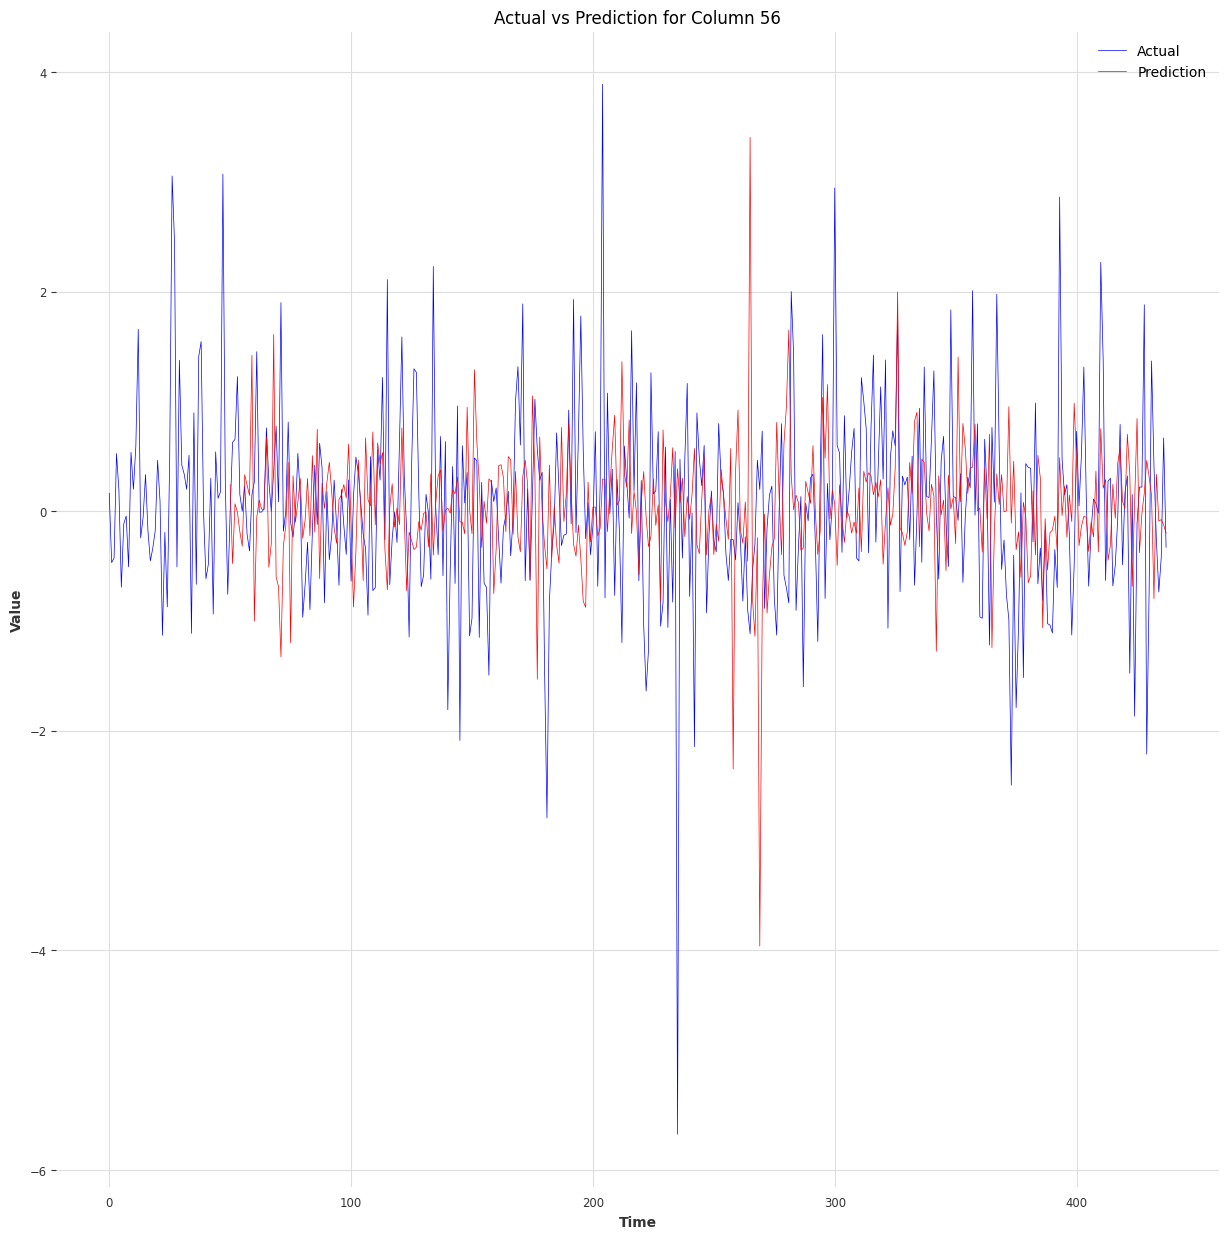

In [44]:
# Convert TimeSeries to DataFrame
test_df = test_series.pd_dataframe()
forecast_df = model_forecasting.pd_dataframe()

# Randomly select a column
column_index = random.randint(0, len(test_df.columns) - 1)
column_name = test_df.columns[column_index]

# Extract the selected column
selected_actual_column = test_df[column_name]
selected_predicted_column = forecast_df[column_name]

# Plot the selected column
fig, ax = plt.subplots(figsize=(15, 15))

# Plot actual values
ax.plot(selected_actual_column, label="Actual", linewidth=0.5, color='blue')

# Plot predicted values
ax.plot(selected_predicted_column, label="Prediction", linewidth=0.5, color='red')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Actual vs Prediction for Column {column_name}')
plt.legend()
plt.show()

In [45]:
# Extract the anomaly scores from the TimeSeries object
anomaly_scores_array = anomaly_scores.values()

# Flatten the array if it has extra dimensions
anomaly_scores_array = anomaly_scores_array.flatten()

# Step 1: Calculate mean and standard deviation
mean = np.mean(anomaly_scores_array)
std_dev = np.std(anomaly_scores_array)

# Step 2: Compute Z-scores
z_scores = (anomaly_scores_array - mean) / std_dev

# Step 3: Define the threshold (e.g., 3 standard deviations)
threshold = 3  # You can adjust this value as needed

# Step 4: Identify anomalies
binary_anomalies = (np.abs(z_scores) > threshold).astype(int)

# Print results
print("Anomaly Scores:", anomaly_scores_array)
print("Z-Scores:", z_scores)
print("Binary Anomalies:", binary_anomalies)

# Optional: Create a DataFrame for easier viewing
df = pd.DataFrame({
    'Anomaly Score': anomaly_scores_array,
    'Z-Score': z_scores,
    'Anomaly (1 if anomaly, 0 if normal)': binary_anomalies
})

print(df)

Anomaly Scores: [ 88.64206   86.28466  112.18175  202.4357    60.368736  53.406326
 114.375854  82.938095  92.96953   94.87616  118.7084   165.94403
  82.20909  103.34938   77.56347   63.33548   73.09427   71.78349
 143.58583  111.41335   56.31279  308.05298   44.739037 146.77185
 136.5296   185.13321   78.464325  99.004814  64.10404  122.77433
 115.66109   88.698425  52.732395 145.1976   107.105804  80.681885
  87.70128   98.902374  36.21501  102.51542   83.01462   73.61964
  51.596634 138.65207   61.841778  47.851227 151.5325    46.617985
  99.91517  146.20181  107.1534    88.038704  87.18294  105.372925
  50.068794  63.485077  77.246025 139.26605   66.89628  106.47463
  80.02001  150.26158   98.76411   66.196304  52.787632 395.77588
  68.83106   79.36676   88.08397   56.98671  274.07904  137.46657
  75.09511   65.00391  154.11772   83.67737  241.3644   217.07547
  57.630783  81.03984  100.539     47.561977  92.87558  110.50095
 270.3335    73.1564   156.17677  146.17511  190.08952  

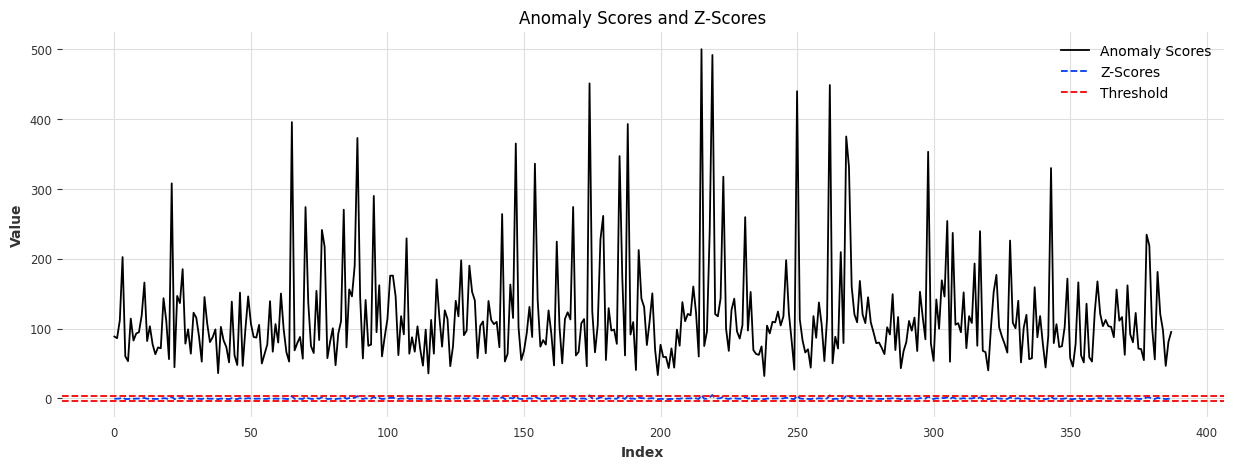

In [46]:
# If you want to plot, ensure you only plot a subset if the data is large
plt.figure(figsize=(15, 5))
plt.plot(anomaly_scores_array, label="Anomaly Scores")
plt.plot(z_scores, label="Z-Scores", linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Anomaly Scores and Z-Scores")
plt.show()

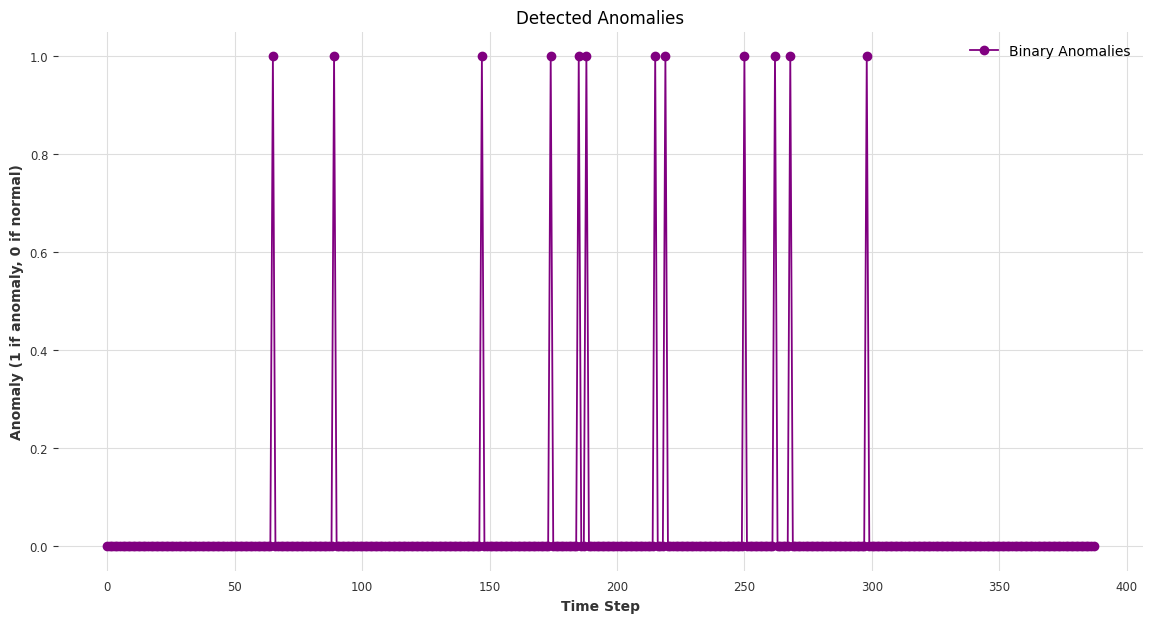

In [47]:
# Plot Binary Anomalies
plt.figure(figsize=(14, 7))
plt.plot(binary_anomalies, label='Binary Anomalies', color='purple', marker='o')
plt.title('Detected Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Anomaly (1 if anomaly, 0 if normal)')
plt.legend()
plt.show()

In [48]:
# Assuming you have binary_anomalies array from your previous steps
# Convert binary anomalies to a DataFrame
anomalies_df = pd.DataFrame(binary_anomalies, columns=['Anomalies'])

# Create TimeSeries object for binary anomalies
binary_anomalies_series = TimeSeries.from_dataframe(anomalies_df)

# Define metrics to evaluate
metric_names = ["AUC_ROC", "AUC_PR"]
metric_data = []

# Compute metrics
for metric_name in metric_names:
    metric_data.append(
        anomaly_model.eval_metric(
            anomalies=binary_anomalies_series,
            series=test_series,
            start=START,
            metric=metric_name,
        )
    )

# Create DataFrame to display the metrics
metrics_df = pd.DataFrame(data=metric_data, index=metric_names).T
print(metrics_df)


`start` value `0.1` corresponding to timestamp `43` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 50. To hide these warnings, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`start` value `0.1` corresponding to timestamp `43` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 50. To hide these warnings, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


                   AUC_ROC    AUC_PR
Norm (ord=1)_w=1  0.513292  0.040068


`start` value `0.1` corresponding to timestamp `43` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 50. To hide these warnings, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


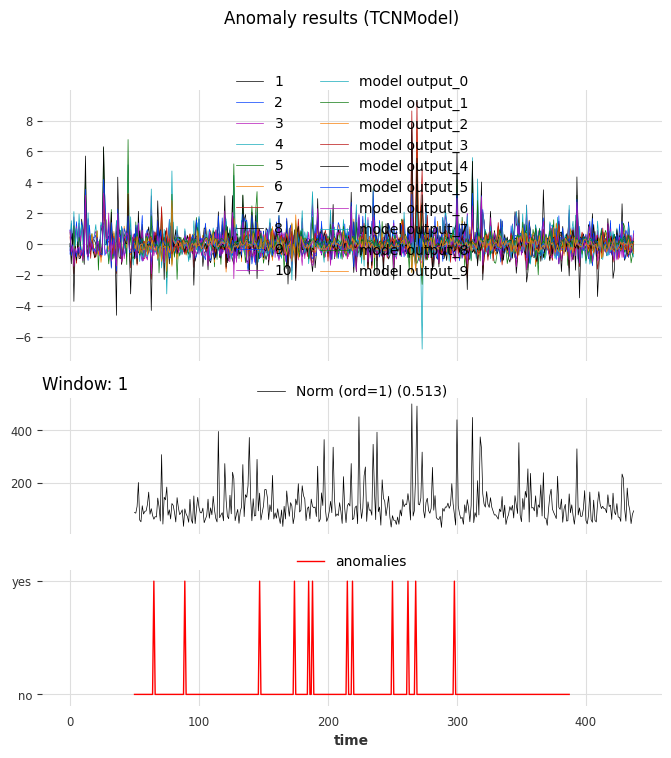

In [49]:
# Convert binary anomalies to DataFrame
anomalies_df = pd.DataFrame(binary_anomalies, columns=['Anomalies'])

# Create TimeSeries object for binary anomalies
binary_anomalies_series = TimeSeries.from_dataframe(anomalies_df)

# Align anomalies series with your test series
binary_anomalies_series = binary_anomalies_series[pred_start:]

# Call show_anomalies with the correct arguments
anomaly_model.show_anomalies(
    series=test_series,                # Replace with your actual time series data
    anomalies=binary_anomalies_series,  # Binary anomalies in TimeSeries format
    start=START,
    metric="AUC_ROC",                  # Metric name for evaluation
)


`start` value `0.1` corresponding to timestamp `43` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 50. To hide these warnings, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


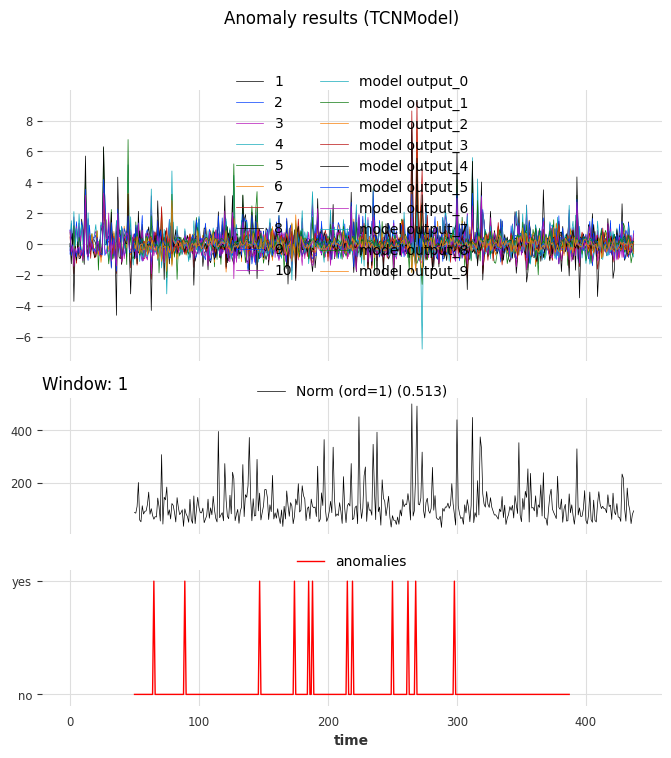

In [50]:
import pandas as pd
from darts import TimeSeries

# Convert binary anomalies to DataFrame
anomalies_df = pd.DataFrame(binary_anomalies, columns=['Anomalies'])

# Create TimeSeries object for binary anomalies
binary_anomalies_series = TimeSeries.from_dataframe(anomalies_df)

# Align anomalies series with your test series
binary_anomalies_series = binary_anomalies_series[pred_start:]

# Call show_anomalies with the correct arguments
anomaly_model.show_anomalies(
    series=test_series,                # Replace with your actual time series data
    anomalies=binary_anomalies_series,  # Binary anomalies in TimeSeries format
    start=START,
    metric="AUC_ROC",                  # Metric name for evaluation
)


In [51]:
contamination = 0.95
detector = QuantileDetector(high_quantile=contamination)

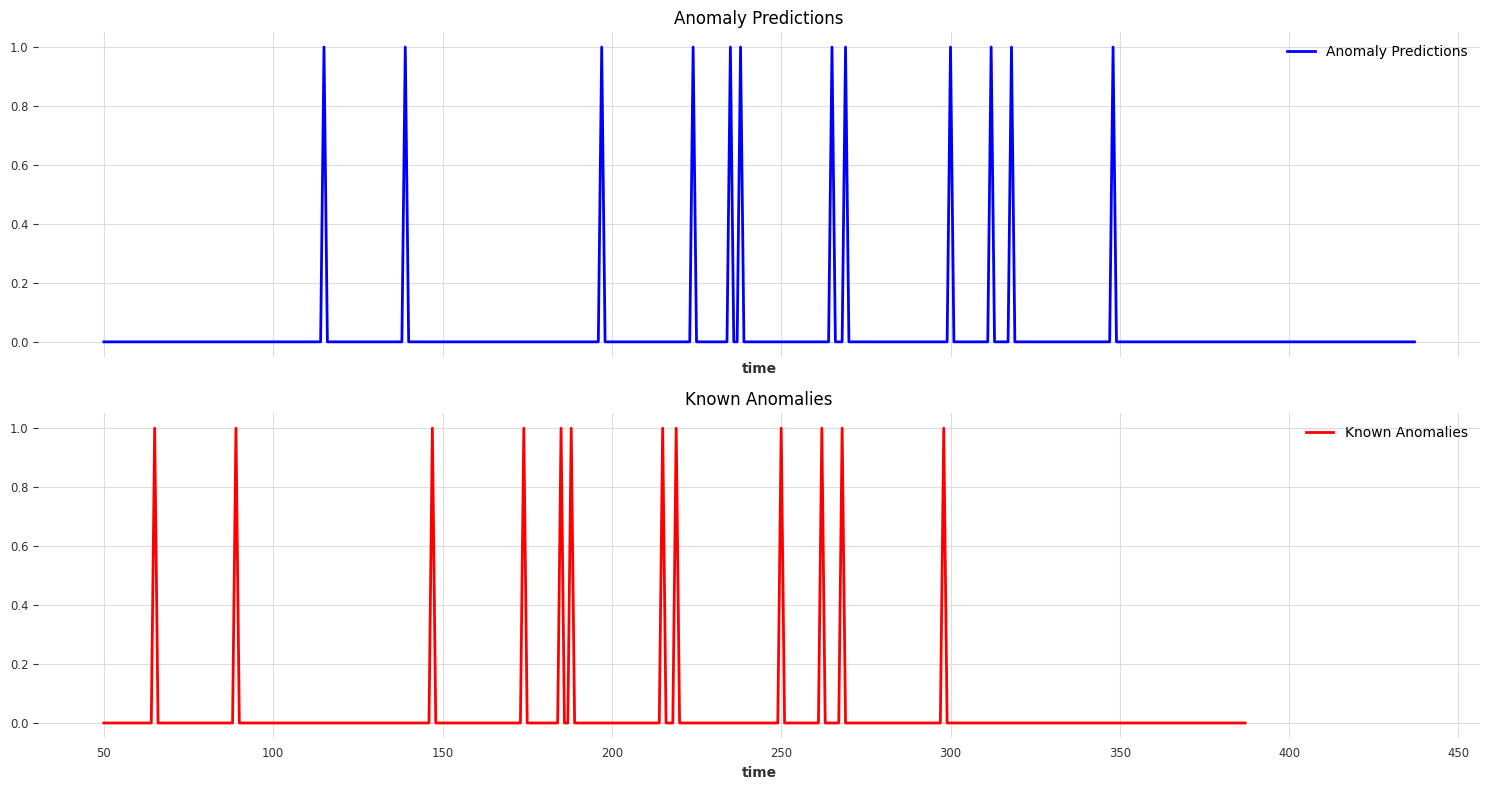

In [52]:
# Extract the anomaly scores from the TimeSeries object
anomaly_scores_array = anomaly_scores.values().flatten()

# Calculate mean and standard deviation for z-score thresholding
mean = np.mean(anomaly_scores_array)
std_dev = np.std(anomaly_scores_array)
threshold = 3  # 3 standard deviations for anomaly detection

# Compute z-scores and determine anomalies
z_scores = (anomaly_scores_array - mean) / std_dev
binary_anomalies = (np.abs(z_scores) > threshold).astype(int)

# Convert binary anomalies to a TimeSeries object
# Use the time index from anomaly_scores
anomaly_pred_df = pd.DataFrame(
    binary_anomalies, 
    columns=['anomaly'], 
    index=anomaly_scores.time_index  # Directly access the attribute
)
anomaly_pred_series = TimeSeries.from_dataframe(anomaly_pred_df)

# Ensure series_taxi_anomalies is correctly defined and in TimeSeries format
# Example of creating a TimeSeries object from a DataFrame (if needed)
# series_taxi_anomalies = TimeSeries.from_dataframe(pd.DataFrame({'value': ...}))

# Plot binary predictions and known anomalies
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15, 8))

# Plot anomaly predictions
anomaly_pred_series.plot(label="Anomaly Predictions", ax=ax1, color="blue")
ax1.set_title("Anomaly Predictions")
ax1.legend()

# Plot known anomalies (ensure series_taxi_anomalies is a TimeSeries object)
binary_anomalies_series.plot(label="Known Anomalies", ax=ax2, color="red")
ax2.set_title("Known Anomalies")
ax2.legend()

fig.tight_layout()
plt.show()

In [54]:
# Ensure you have the necessary libraries and your detector is correctly defined

# Define the metrics you want to evaluate
metric_names = ["accuracy", "precision", "recall", "f1"]

# Loop over each metric and evaluate
for metric_name in metric_names:
    # Use detector to evaluate the metrics
    metric_val = detector.eval_metric(
        pred_scores=best_anomaly_score,
        anomalies=binary_anomalies_series,
        metric=metric_name
    )
    # Print the result formatted to two decimal places
    print(f"{metric_name.capitalize()}: {metric_val:.2f}/1")

NameError: name 'best_anomaly_score' is not defined

In [ ]:
# Define appropriate window sizes for ECG 5000 dataset
windows = [50, 100, 200]  # Adjust these sizes based on the dataset and desired sensitivity

# Define the scorer names based on the model's scorers and the windows
scorer_names = [f"{scorer}_{w}" for scorer, w in zip(["accuracy", "precision", "recall", "f1"], windows)]

# Initialize a dictionary to store metric results
metric_data = {metric: [] for metric in ["accuracy", "precision", "recall", "f1", "AUC_ROC", "AUC_PR"]}

# Function to evaluate standard metrics
def eval_metric_from_scores(anomalies, pred_scores, window, metric):
    return detector.eval_metric(
        pred_scores=pred_scores,
        anomalies=anomalies,
        window=window,
        metric=metric
    )

# Compute standard metrics
for metric_name in metric_data:
    if metric_name in ["accuracy", "precision", "recall", "f1"]:
        for window in windows:
            metric_val = eval_metric_from_scores(
                anomalies=binary_anomalies_series,
                pred_scores=best_anomaly_score,
                window=window,
                metric=metric_name
            )
            metric_data[metric_name].append(metric_val)

# Compute AUC_ROC and AUC_PR metrics separately
def compute_auc_metrics(anomalies, pred_scores):
    # Convert to numpy arrays if necessary
    anomalies = np.asarray(anomalies)
    pred_scores = np.asarray(pred_scores)

    # Ensure the lengths of arrays match
    min_len = min(len(anomalies), len(pred_scores))
    true_labels = anomalies[:min_len]
    scores = pred_scores[:min_len]
    
    auc_roc = roc_auc_score(true_labels, scores)
    auc_pr = average_precision_score(true_labels, scores)
    
    return auc_roc, auc_pr

# Convert series to numpy arrays
anomalies_array = binary_anomalies_series.values() if hasattr(binary_anomalies_series, 'values') else np.asarray(binary_anomalies_series)
scores_array = anomaly_scores.values() if hasattr(anomaly_scores, 'values') else np.asarray(anomaly_scores)

# Ensure the arrays are of the same length
if len(anomalies_array) != len(scores_array):
    min_len = min(len(anomalies_array), len(scores_array))
    anomalies_array = anomalies_array[:min_len]
    scores_array = scores_array[:min_len]

auc_roc, auc_pr = compute_auc_metrics(anomalies_array, scores_array)
metric_data["AUC_ROC"] = [auc_roc] * len(windows)
metric_data["AUC_PR"] = [auc_pr] * len(windows)

# Convert metric_data to a DataFrame
results_df = pd.DataFrame(data=metric_data, index=scorer_names)

# Display the results
print(results_df)

In [ ]:
# Extract the index and ensure alignment
test_series_df = test_series.pd_dataframe()
test_series_index = test_series_df.index

# Extract anomaly scores as DataFrame and align
if isinstance(anomaly_scores, TimeSeries):
    anomaly_scores_df = anomaly_scores.pd_dataframe()
else:
    raise ValueError("anomaly_scores should be a TimeSeries object")

# Ensure lengths match: truncate or adjust anomaly_scores
if len(anomaly_scores_df) > len(test_series_index):
    anomaly_scores_df = anomaly_scores_df.loc[test_series_index]

# If anomaly_scores is shorter, you may need to handle padding or truncation
elif len(anomaly_scores_df) < len(test_series_index):
    # Optional: Pad anomaly_scores_df with NaNs or zeros
    anomaly_scores_df = anomaly_scores_df.reindex(test_series_index, method='ffill')  # Forward fill

# Create DataFrame from the anomaly scores array
pred_scores_df = pd.DataFrame({'score': anomaly_scores_df.values.flatten()}, index=test_series_index)

# Convert DataFrame to TimeSeries
pred_scores_series = TimeSeries.from_dataframe(pred_scores_df)
forecasting_series = model_forecasting  # Ensure this is in TimeSeries format

# Define the windows and scorer names
windows = [50, 100, 200]  # Example windows
scorer_names = ["scorer1_50", "scorer1_100", "scorer1_200"]  # Replace with actual scorer names

# Define the title and metric
title = "Anomaly results using a forecasting method"
metric = "AUC_ROC"  # Ensure this metric is available and valid

# Plot function
def show_anomalies_from_scores(series, anomalies, pred_scores, pred_series, window, title, names_of_scorers, metric):
    fig, ax = plt.subplots(nrows=3, figsize=(14, 10), sharex=True)

    # Plot actual series
    series.plot(ax=ax[0], label='Actual Series')
    ax[0].set_title('Time Series')
    ax[0].legend()

    # Plot anomaly scores
    pred_scores.plot(ax=ax[1], label='Anomaly Scores', color='orange')
    ax[1].set_title('Anomaly Scores')
    ax[1].legend()

    # Plot anomalies
    anomalies.plot(ax=ax[2], label='Anomalies', color='red')
    ax[2].set_title('Anomalies')
    ax[2].legend()

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Call the function
show_anomalies_from_scores(
    series=test_series,
    anomalies=anomalies_series,
    pred_scores=pred_scores_series,
    pred_series=forecasting_series,
    window=windows,  # Adjust or remove if not used in the function
    title=title,
    names_of_scorers=scorer_names,
    metric=metric
)

# Whatsapp images

In [ ]:
# Score the validation data
START = 0.1
anomaly_scores, _ = anomaly_model.score(val_series, start=START, return_model_prediction=False, verbose=True)

# Extract the scores from the output
scores = anomaly_scores.values()  # Adjust based on how the scores are structured

# Decide a threshold for anomaly detection
# One common approach is to use a percentile-based threshold
threshold_percentile = 95  # You can adjust this percentile
threshold = np.percentile(scores, threshold_percentile)

# Print or log the threshold
print(f"Decided threshold for anomaly detection: {threshold}")

# Optionally, visualize the scores and threshold
plt.figure(figsize=(12, 6))
plt.plot(scores, label="Anomaly Scores")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold ({threshold})")
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Scores and Threshold')
plt.legend()
plt.show()

# Apply the threshold to classify anomalies
anomalies = scores > threshold

# Print the indices or time points where anomalies are detected
print("Anomalies detected at indices:", np.where(anomalies)[0])